In [1]:
from modules.models import KdVPinn, create_dense_model
from modules.data import simulate_kdv
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np

2023-05-09 20:29:48.615395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
k=6
c=5
phi = 0
def phi_function(tx):
    offset =  + 16
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    return c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

# x_start = 0
# length = 8*np.pi
x_start = -20
length = 20
time =  np.pi/2

In [3]:
(tx_samples, y_res), (tx_init, u_init), (tx_bnd, u_bnd) = simulate_kdv(2000, phi_function, boundary_function, x_start, length=length, time=1, random_seed=42, dtype=tf.float32)

2023-05-09 20:33:46.116673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


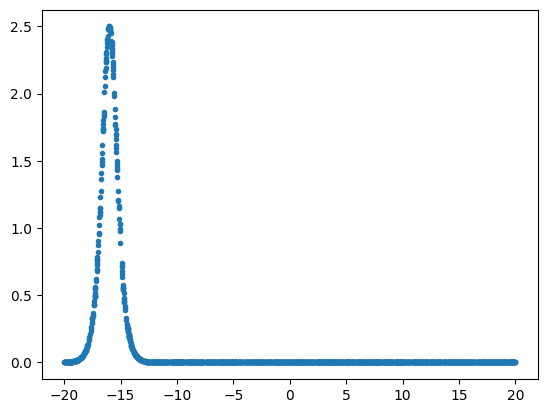

In [4]:
import matplotlib.pyplot as plt
plt.plot( tx_init[:,1:],u_init,'.')
inputs = [tx_samples, tx_init, tx_bnd]
outputs = [phi_function(tx_samples), y_res, u_init, u_bnd]

In [5]:
backbone = create_dense_model([64, 64, 64], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)

In [6]:
pinn = KdVPinn(backbone, k=k)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.92)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn.compile(optimizer=optimizer)

In [7]:
history = pinn.fit(inputs, outputs, epochs=20000, batch_size=500, verbose=0)

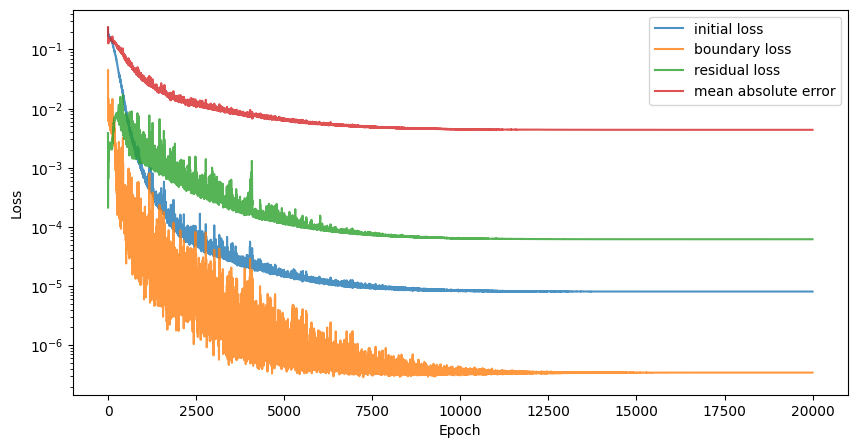

In [8]:
plot_training_loss(history.history, y_scale='log')

1/1 [==============================] - 0s 26ms/step


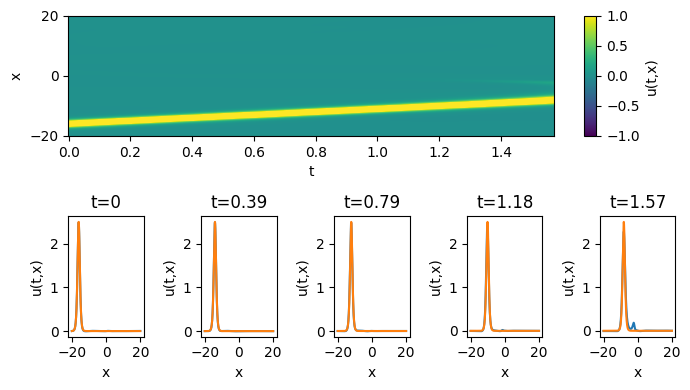

In [18]:
plot_KdV_model(pinn.backbone, x_start,length, time, save_path = None, show=True) 

In [33]:
def plot_snapshots(timeList,num_test_samples = 1000):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction')
        plt.plot(x_flat, phi_function(tx), label = 'exact')
        plt.legend()
        plt.title('t={}'.format(np.round(t_cs,2)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
        return

1/1 [==============================] - 0s 52ms/step


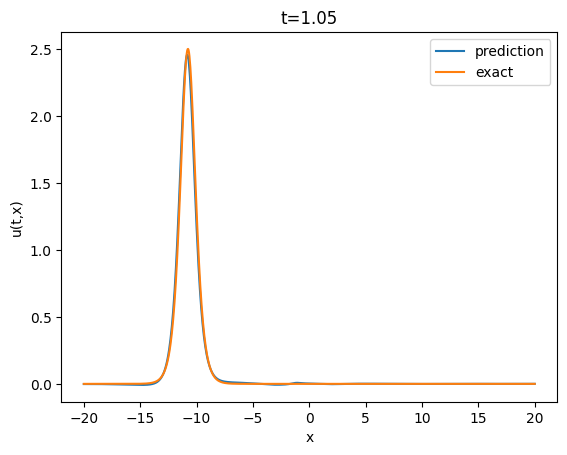

In [34]:
plot_snapshots([time/1.5])